Training REINFORCE with Baseline...
Episode 0: Average Reward = -100.00
Episode 10: Average Reward = -57.90
Episode 20: Average Reward = -65.60
Episode 30: Average Reward = -49.20
Episode 40: Average Reward = 17.80
Episode 50: Average Reward = -56.30
Episode 60: Average Reward = -1.10
Episode 70: Average Reward = 0.20
Episode 80: Average Reward = 39.00
Episode 90: Average Reward = -2.30
Episode 100: Average Reward = 23.80
Episode 110: Average Reward = -28.80
Episode 120: Average Reward = -1.90
Episode 130: Average Reward = 7.00
Episode 140: Average Reward = 45.40
Episode 150: Average Reward = 64.90
Episode 160: Average Reward = 62.30
Episode 170: Average Reward = 81.10
Episode 180: Average Reward = 49.80
Episode 190: Average Reward = 56.60
Episode 200: Average Reward = 77.20
Episode 210: Average Reward = 58.60
Episode 220: Average Reward = 43.70
Episode 230: Average Reward = 61.00
Episode 240: Average Reward = 32.10
Episode 250: Average Reward = 54.70
Episode 260: Average Reward = 75.6

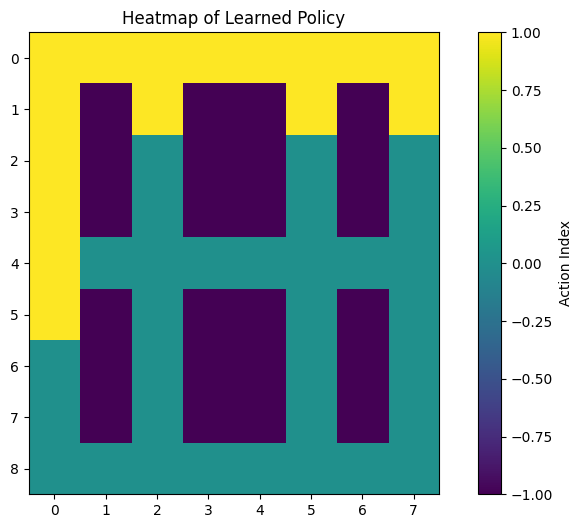

Plotting Training Rewards...


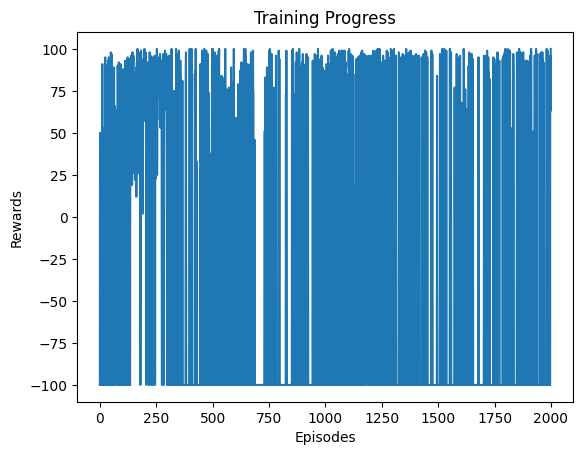

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Warehouse Agent
class warehouse_agent:
    def __init__(self, rows, columns):
        self.A = np.array([0, 1, 2, 3])  # Actions: ['Up', 'Right', 'Down', 'Left']
        self.P = np.array([0.95, 0.97, 0.99, 1.0])  # Reduced stochasticity
        self.rows = rows
        self.columns = columns
        self.reward = None
        self.terminal_states = None
        self.H = None  # environment height
        self.W = None  # environment width
        self._generate_environment(rows, columns)

    def _generate_environment(self, rows, columns):
        self.H = 3 * rows + rows + 1
        self.W = 3 * columns + 2
        reward = -np.ones((self.H, self.W))
        reward[:, np.arange(1, self.W - 3, 3)] = -9
        reward[:, np.arange(3, self.W, 3)] = -9
        reward[np.arange(0, self.H, 4)] = -1
        reward[2, 2] = 100
        self.reward = reward
        self.terminal_states = np.array([[2, 2]])

    def generate_ini_state(self, terminate_x, terminate_y):
        while True:
            x = np.random.randint(0, self.H)
            y = np.random.randint(0, self.W)
            if (x, y) != (terminate_x, terminate_y) and self.reward[x, y] != -9:
                return [x, y]

    def apply_transition_function(self, intended_action):
        c = np.random.rand()
        if c < self.P[0]:
            return intended_action
        elif c < self.P[1]:
            return (intended_action - 1) % len(self.A)
        elif c < self.P[2]:
            return (intended_action + 1) % len(self.A)
        else:
            return None

    def computeNextPosition(self, row, col, action):
        if action is None:
            return int(row), int(col)

        new_row, new_col = int(row), int(col)
        if action == 0:
            new_row -= 1
        elif action == 1:
            new_col += 1
        elif action == 2:
            new_row += 1
        elif action == 3:
            new_col -= 1

        if (
            new_row < 0
            or new_row >= self.H
            or new_col < 0
            or new_col >= self.W
            or self.reward[new_row, new_col] == -9
        ):
            return int(row), int(col)
        return int(new_row), int(new_col)


# Policy Network for REINFORCE
class PolicyNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(PolicyNetwork, self).__init__()
        self.dense1 = layers.Dense(128, activation="relu")
        self.policy_logits = layers.Dense(num_actions, activation="softmax")

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.policy_logits(x)


# Value Network (Baseline) for REINFORCE
class ValueNetwork(tf.keras.Model):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = layers.Dense(128, activation="relu")
        self.value = layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.value(x)


# Training REINFORCE with Baseline
def train_reinforce_with_baseline(agent, policy_model, value_model, episodes=500, gamma=0.93, learning_rate=0.0004, max_steps=100):
    policy_optimizer = tf.keras.optimizers.Adam(learning_rate)
    value_optimizer = tf.keras.optimizers.Adam(learning_rate)
    total_rewards = []

    for episode in range(episodes):
        state = agent.generate_ini_state(agent.terminal_states[0][0], agent.terminal_states[0][1])
        state = np.expand_dims(np.array(state, dtype=np.float32), axis=0)

        episode_states, episode_actions, episode_rewards = [], [], []
        done = False
        steps = 0

        while not done and steps < max_steps:
            steps += 1
            action_probs = policy_model(state)
            action = np.random.choice(len(agent.A), p=np.squeeze(action_probs))
            real_action = agent.apply_transition_function(action)
            next_state = agent.computeNextPosition(state[0, 0], state[0, 1], real_action)
            reward = agent.reward[next_state[0], next_state[1]]
            done = (np.array(next_state) == agent.terminal_states[0]).all()

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)

            state = np.expand_dims(np.array(next_state, dtype=np.float32), axis=0)

        total_rewards.append(sum(episode_rewards))
        returns = compute_discounted_rewards(episode_rewards, gamma)

        for state, action, G in zip(episode_states, episode_actions, returns):
            with tf.GradientTape(persistent=True) as tape:
                state_value = value_model(state)
                action_probs = policy_model(state)
                advantage = G - state_value

                policy_loss = -tf.math.log(action_probs[0, action]) * advantage
                value_loss = tf.square(advantage)

            policy_grads = tape.gradient(policy_loss, policy_model.trainable_variables)
            value_grads = tape.gradient(value_loss, value_model.trainable_variables)
            policy_optimizer.apply_gradients(zip(policy_grads, policy_model.trainable_variables))
            value_optimizer.apply_gradients(zip(value_grads, value_model.trainable_variables))

        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards[-10:])
            print(f"Episode {episode}: Average Reward = {avg_reward:.2f}")

    return total_rewards


# Compute Discounted Rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0
    for t in reversed(range(len(rewards))):
        cumulative = cumulative * gamma + rewards[t]
        discounted_rewards[t] = cumulative
    return discounted_rewards


# Generate Learned Policy
def generate_learned_policy(agent, policy_model):
    policy = np.full((agent.H, agent.W), -1)
    for row in range(agent.H):
        for col in range(agent.W):
            if agent.reward[row, col] == -9:
                continue
            state = np.expand_dims(np.array([row, col], dtype=np.float32), axis=0)
            action_probs = policy_model(state)
            best_action = np.argmax(action_probs)
            policy[row, col] = best_action
    return policy


# Display Policy with Arrows
def display_policy_with_arrows(agent, policy):
    action_map = {0: "↑", 1: "→", 2: "↓", 3: "←", -1: "█"}
    visual = np.empty(policy.shape, dtype=str)
    for row in range(agent.H):
        for col in range(agent.W):
            visual[row, col] = action_map[policy[row, col]]
    for row in visual:
        print(" ".join(row))


# Plot Heatmap
def plot_heatmap(agent, policy):
    plt.figure(figsize=(10, 6))
    plt.imshow(policy, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Action Index")
    plt.title("Heatmap of Learned Policy")
    plt.show()


# Plot Rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Training Progress")
    plt.show()


# Testing the Learned Policy
def test_policy(agent, policy_model):
    state = agent.generate_ini_state(agent.terminal_states[0][0], agent.terminal_states[0][1])
    state = np.expand_dims(np.array(state, dtype=np.float32), axis=0)
    total_reward = 0
    done = False

    while not done:
        action_probs = policy_model(state)
        action = np.argmax(action_probs)
        real_action = agent.apply_transition_function(action)
        next_state = agent.computeNextPosition(state[0, 0], state[0, 1], real_action)
        reward = agent.reward[next_state[0], next_state[1]]
        done = (np.array(next_state) == agent.terminal_states[0]).all()
        total_reward += reward
        state = np.expand_dims(np.array(next_state, dtype=np.float32), axis=0)
    print(f"Total Test Reward: {total_reward}")


# Main Script
if __name__ == "__main__":
    agent = warehouse_agent(rows=2, columns=2)
    policy_model = PolicyNetwork(len(agent.A))
    value_model = ValueNetwork()

    print("Training REINFORCE with Baseline...")
    rewards = train_reinforce_with_baseline(agent, policy_model, value_model, episodes=2000)

    print("Testing the learned policy...")
    test_policy(agent, policy_model)

    print("Generating Learned Policy...")
    learned_policy = generate_learned_policy(agent, policy_model)

    print("Displaying Learned Policy with Arrows...")
    display_policy_with_arrows(agent, learned_policy)

    print("Plotting Heatmap of Learned Policy...")
    plot_heatmap(agent, learned_policy)

    print("Plotting Training Rewards...")
    plot_rewards(rewards)
